# Deep Learning (TensorFlow, Keras) with ResNet50: Image Multi-class Classifier (Part 3)
In this project, a model is trained to perform multi-class classification for apple, banana and orange pictures. The pretrained model ResNet50 is used. This document is the third part of the whole training process.

## Iteration 3: Model retraining, learning_rate=1e-4, no data augmentation and fine-tuning (last 20 layers)

In [1]:
# (height, width, channels)
input_shape = (224, 224, 3)
batch_size = 12
learning_rate = 1e-4
path_dataset = '../fruits_dataset'
folder_apple = 'apple'
folder_banana = 'banana'
folder_orange = 'orange'
folder_models = '../models'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

2025-10-23 21:55:06.848624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 21:55:11.588604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 21:55:11.596383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 21:55:19.211467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### No data augmentation

In [3]:
def load_data(path, input_shape=input_shape, batch_size=batch_size, seed=123, validation_split=0.2):
    """Function to create 2 ImageDataGenerators to split dataset into train and validation datasets.
    Data augmentation is not implemented for the validation dataset."""
    height, width = input_shape[:2]
    datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0,
        horizontal_flip=True, vertical_flip=False,
        height_shift_range=0, width_shift_range=0,
        brightness_range=(0.99, 1.01), rotation_range=0,
        validation_split=validation_split
    )
    train_data = datagen.flow_from_directory(path,
        target_size=(height, width), batch_size=batch_size,
        class_mode='sparse', subset='training', seed=seed
    )
    val_datagen = ImageDataGenerator(rescale=1.0/255,
        validation_split=validation_split
    )
    val_data = val_datagen.flow_from_directory(path,
        target_size=(height, width), batch_size=batch_size,
        class_mode='sparse', subset='validation', seed=seed
    )
    return train_data, val_data

# Split training and validation datasets
train, val = load_data(path_dataset)

print(f"Classes found: {train.class_indices}")
print(f"Training images: {train.samples}")
print(f"Validation images: {val.samples}")

Found 2070 images belonging to 3 classes.
Found 516 images belonging to 3 classes.
Classes found: {'apple': 0, 'banana': 1, 'orange': 2}
Training images: 2070
Validation images: 516


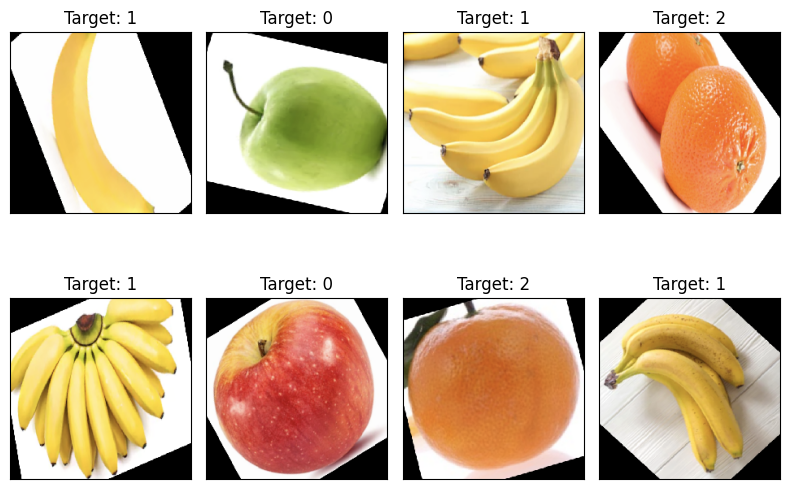

(12, 224, 224, 3)


In [4]:
# Obtain images and target
images, labels = next(train)

# Show 8 training images (batch_size=8)
figure, axes = plt.subplots(nrows=2,ncols=4, figsize=(8, 6))
for item in zip(axes.ravel(), images, labels):
    axes, image, target = item
    axes.imshow(image)
    axes.set_title(f'Target: {target:0.0f}')
    axes.set_xticks([])
    axes.set_yticks([])
plt.tight_layout()
plt.show()

# Image dimensions
print(images.shape)

### Model retraining (iteration 3)

In [6]:
def train_model(model, train_data, val_data, epochs, version_model):
    """Function to train the model and save the best one
    according to the validation accuracy."""
    file_name = os.path.join(folder_models,f'sparse_model_v{version_model}.h5')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=0),
        ModelCheckpoint(file_name, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = model.fit(train_data, validation_data=val_data,
              epochs=epochs, callbacks=callbacks, verbose=2)

    return model, history

# Load model v2
model_v3 = load_model(os.path.join(folder_models,'sparse_model_v2.h5'))
model_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23850371 (90.98 MB)
Trainable params: 4728323 (18.04 MB)
Non-trainable params: 19122048 (72.94 MB)
_________________________________________________________________


In [7]:
epochs = 30
version_model = 3
print(f"Parameters: batch_size = {batch_size}, learning_rate = {learning_rate}, epochs = {epochs}")

Parameters: batch_size = 12, learning_rate = 0.0001, epochs = 30


In [8]:
# Last 20 layers
for layer in model_v3.layers[0].layers[-20:]:
    layer.trainable = True

# Recompile
model_v3.compile(optimizer=Adam(learning_rate=learning_rate),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"TensorFlow Version: {tf.__version__}")

# Ensure GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    print("GPU is available and memory growth is enabled.")
else:
    print("GPU not available, training will be on CPU.")

TensorFlow Version: 2.13.1
GPU not available, training will be on CPU.


In [9]:
# Retrain the model
model_v3, history_stage3 = train_model(model_v3, train, val, epochs=epochs, version_model=version_model)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.57171, saving model to ../models/sparse_model_v3.h5


/home/ant/TensorFlow-Keras-Multi-class-Classifier/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 - 292s - loss: 0.8248 - accuracy: 0.6560 - val_loss: 0.9195 - val_accuracy: 0.5717 - lr: 1.0000e-04 - 292s/epoch - 2s/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.57171 to 0.65698, saving model to ../models/sparse_model_v3.h5
173/173 - 248s - loss: 0.5512 - accuracy: 0.7643 - val_loss: 0.8924 - val_accuracy: 0.6570 - lr: 1.0000e-04 - 248s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.65698 to 0.76357, saving model to ../models/sparse_model_v3.h5
173/173 - 246s - loss: 0.4553 - accuracy: 0.8159 - val_loss: 0.7088 - val_accuracy: 0.7636 - lr: 1.0000e-04 - 246s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.76357
173/173 - 239s - loss: 0.4086 - accuracy: 0.8353 - val_loss: 0.9044 - val_accuracy: 0.6492 - lr: 1.0000e-04 - 239s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.76357
173/173 - 254s - loss: 0.3685 - accuracy: 0.8541 - val_loss: 1.1565 - val_accuracy: 0.6453 - lr: 1.0000e-04 - 254s/epoch - 1

**Result 3:** val_accuracy=93%.

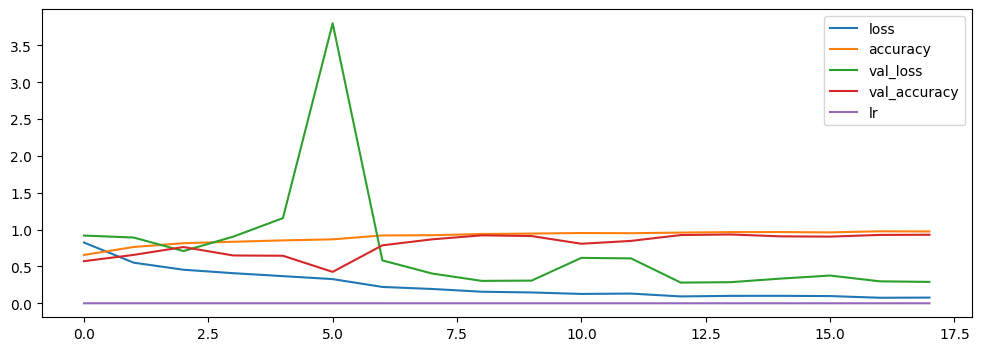

In [10]:
pd.DataFrame(history_stage3.history).plot(figsize=(12, 4))
plt.show()

In [ ]:
# Save model
# model.save(os.path.join(folder_models,f'sparse_model_v{version_model}.keras'))